**Connecting to Google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading all necessary libraries for image processing, model building, and evaluation.**

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

**Data loading from saved** **folder** - Load the image dataset for training, validation, and testing from the specified directory.

In [3]:
main_path = '/content/drive/MyDrive/140K_code/140K_Dataset_3000_images'

train_dir = os.path.join(main_path, 'Train')
valid_dir = os.path.join(main_path, 'Validation')
test_dir = os.path.join(main_path, 'Test')

Each directory is organized into two subfolders: **`Fake`** and **`Real`**, representing the two classes of the dataset.


In [4]:
print("Train_dir Subfolders: ", sorted(os.listdir(train_dir)))
print("Valid_dir Subfolders: ", sorted(os.listdir(valid_dir)))
print("Test_dir Subfolders: ", sorted(os.listdir(test_dir)))


Train_dir Subfolders:  ['Fake', 'Real']
Valid_dir Subfolders:  ['Fake', 'Real']
Test_dir Subfolders:  ['Fake', 'Real']


**Exploratory Data Analysis (EDA) – Overview**
As part of the initial EDA, we construct a dictionary with the following keys:

folder: Indicates the dataset split — train, validation, or test.

image_path: Stores the file path for each image.

label: Specifies the image classification label — Fake or Real.



In [5]:
main_path = '/content/drive/MyDrive/140K_code/140K_Dataset_3000_images'
images_df = {"folder": [], "label": [], "image_path": []}

for folder in os.listdir(main_path):
    folder_path = os.path.join(main_path, folder)
    if os.path.isdir(folder_path):  # ✅ check if it's a directory
        for label in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label)
            if os.path.isdir(label_path):  # ✅ check if it's a directory
                for img in glob.glob(os.path.join(label_path, "*.jpg")):
                    images_df["folder"].append(folder)
                    images_df["label"].append(label)
                    images_df["image_path"].append(img)

In [6]:
images_df = pd.DataFrame(images_df)

In [7]:
images_df

folder label                                         image_path
0      Test  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...
1      Test  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...
2      Test  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...
3      Test  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...
4      Test  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...
...     ...   ...                                                ...
2995  Train  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...
2996  Train  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...
2997  Train  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...
2998  Train  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...
2999  Train  Fake  /content/drive/MyDrive/140K_code/140K_Dataset_...

[3000 rows x 3 columns]

**Checking the image count** **and Labels distribution**

In [8]:
real_grouped_df = images_df[images_df['label'] == "Real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "Fake"].groupby('folder')

In [9]:
print(real_grouped_df.size())

folder
Test           300
Train         1050
Validation     150
dtype: int64


In [10]:
print(fake_grouped_df.size())

folder
Test           300
Train         1050
Validation     150
dtype: int64


**As we can see fromt the results, the labels are equally distributed on each folder.**

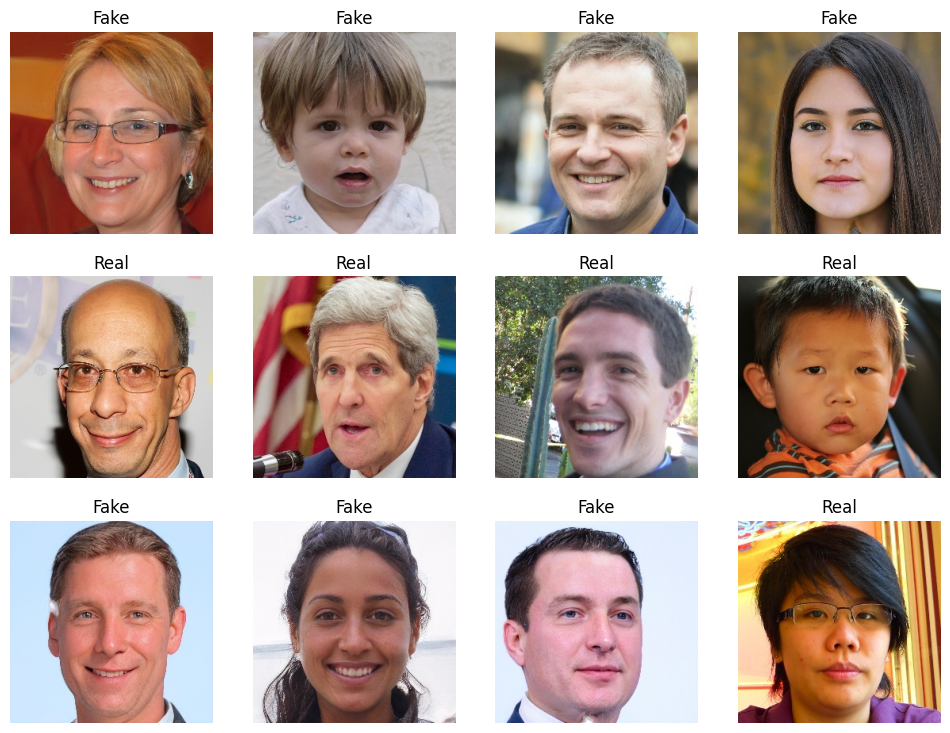

In [11]:
plt.figure(figsize=(12, 9))


fake_images = images_df.sample(12)
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(plt.imread(fake_images["image_path"].values[i]))
    plt.title(fake_images["label"].values[i])
    plt.axis("off")

**Data Preparation for training**


**Data Augmentation**: Enhance your model’s performance with real-time data augmentation using ImageDataGenerator. With horizontal flipping enabled, it automatically expands your dataset by generating mirrored image variations—boosting accuracy through increased image diversity.

In [12]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

**Note**: When shuffle=True, the predictions from test_ds will not align with the ground-truth labels in train_ds.classes. To ensure correct evaluation, make sure to disable shuffling for the test dataset.

In [13]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 2100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


It's visible that all the value are scaled.

In [14]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.8117648  0.7372549  0.60784316]
  [0.8862746  0.8117648  0.68235296]
  [0.9058824  0.8431373  0.7137255 ]
  ...
  [0.2901961  0.35686275 0.15294118]
  [0.43137258 0.49411768 0.2509804 ]
  [0.43921572 0.5019608  0.24705884]]

 [[0.91372555 0.83921576 0.70980394]
  [0.83921576 0.76470596 0.6392157 ]
  [0.86666673 0.80392164 0.6745098 ]
  ...
  [0.28627452 0.34901962 0.16470589]
  [0.37254903 0.43137258 0.21568629]
  [0.42352945 0.48235297 0.2509804 ]]

 [[0.8588236  0.7843138  0.65882355]
  [0.8431373  0.7686275  0.6509804 ]
  [0.8000001  0.73333335 0.6156863 ]
  ...
  [0.27450982 0.32156864 0.18039216]
  [0.3019608  0.3529412  0.18039216]
  [0.38431376 0.43921572 0.24705884]]

 ...

 [[0.8117648  0.8196079  0.8705883 ]
  [0.7607844  0.7686275  0.8196079 ]
  [0.78823537 0.7960785  0.8470589 ]
  ...
  [0.6862745  0.6666667  0.5529412 ]
  [0.69411767 0.67058825 0.5686275 ]
  [0.6784314  0.654902   0.5529412 ]]

 [[0.85098046 0.8588236  0.9176471 ]
  [0.78823537 0.7960785  0.8

Let's print the input shape:


In [15]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 224, 224, 3)
(64,)


In [16]:
train_ds.class_indices

{'Fake': 0, 'Real': 1}

**CNN model architecture (DenseNet121)**

In [17]:
input_shape = (224, 224, 3) #define the input shape of our data

In [18]:
#create the model's architecture and compile it
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [19]:
model_ft = get_model(input_shape)

model_ft.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

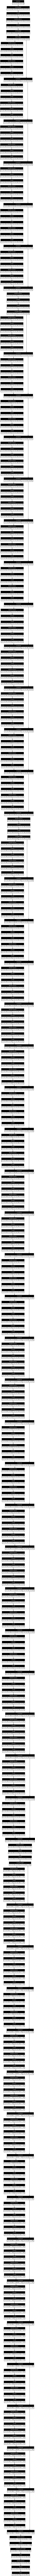

In [20]:
tf.keras.utils.plot_model(model_ft, show_shapes=True)

**ModelCheckpoint**: The ModelCheckpoint callback is used with model.fit() to periodically save the model or its weights during training. This allows training to resume later from the last saved state. It also helps prevent overfitting by enabling early stopping or recovery without losing progress.

In [26]:
#checkpoint_filepath = "model_cp.h5"
checkpoint_filepath = "model_cp.weights.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

**Early Stopping**: The EarlyStopping callback stops training when a monitored metric (in this case val_loss) has stopped improving (in this case decreasing).

In [27]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

**ReduceOnPlateau**: It lowers the learning rate when a metric stops improving for a set number of epochs, helping the model overcome training plateaus.

In [28]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

**Training**

In [29]:
history_ft = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2612s 74s/step - accuracy: 0.6544 - loss: 0.8278 - val_accuracy: 0.5233 - val_loss: 4.2601 - learning_rate: 0.0010
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2436s 72s/step - accuracy: 0.7380 - loss: 0.5561 - val_accuracy: 0.4967 - val_loss: 2.3137 - learning_rate: 0.0010
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2379s 72s/step - accuracy: 0.8597 - loss: 0.3563 - val_accuracy: 0.6900 - val_loss: 0.7398 - learning_rate: 0.0010
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2370s 72s/step - accuracy: 0.8659 - loss: 0.3025 - val_accuracy: 0.5967 - val_loss: 13.9565 - learning_rate: 0.0010
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2368s 72s/step - accuracy: 0.8809 - loss: 0.2900 - val_accuracy: 0.5600 - val_loss: 2.7536 - learning_rate: 0.0010
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2445s 73s/step - accuracy: 0.9351 - loss: 0.1743 - val_accuracy: 0.5033 - val_loss: 6.0853 - learning_rate: 0.0010
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2378s 71s/step - accuracy: 0.9602 - loss: 0.1139 - val

**Result**

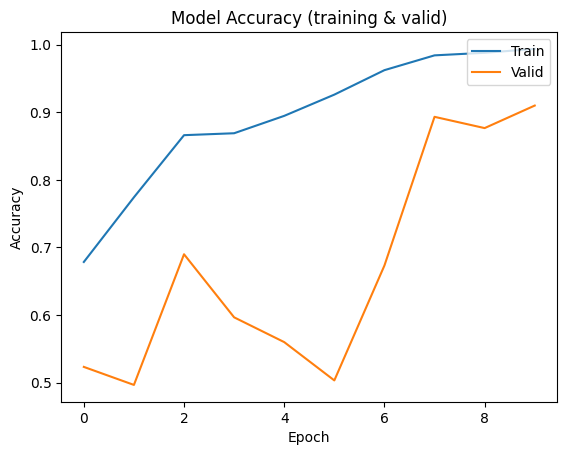

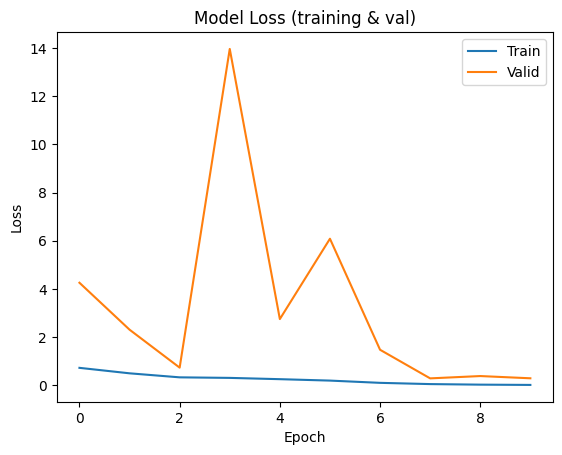

In [30]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

**Evaluation on test set**

In [31]:
# Evaluate the model on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 234s 24s/step - accuracy: 0.8839 - loss: 0.3802
Test Loss: 0.4567709267139435
Test Accuracy: 0.8600000143051147


In [34]:
model = get_model(input_shape)

# Restore the weights
model.load_weights('model_cp.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 738 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [35]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_432']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 152s 14s/step - accuracy: 0.8839 - loss: 0.3802
Test Loss: 0.4567709267139435
Test Accuracy: 0.8600000143051147


**Checking result on Image**

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_432']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Text(0.5, 1.0, 'This image is 99.03% Fake and 0.97% Real.')

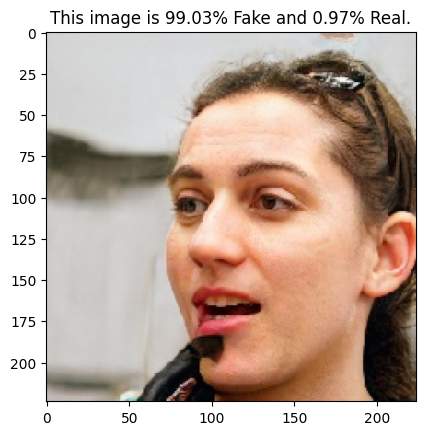

In [36]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/140K_code/140K_Dataset_3000_images/Test/Fake/00F8LKY6JC.jpg', target_size=(224, 224, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

**Quantitative results**

In [37]:
# Assuming you have defined your model as 'model'
predicted_labels = model.predict(test_ds)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_432']
Received: inputs=Tensor(shape=(64, 224, 224, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 150s 14s/step


In [38]:
true_labels = test_ds.classes

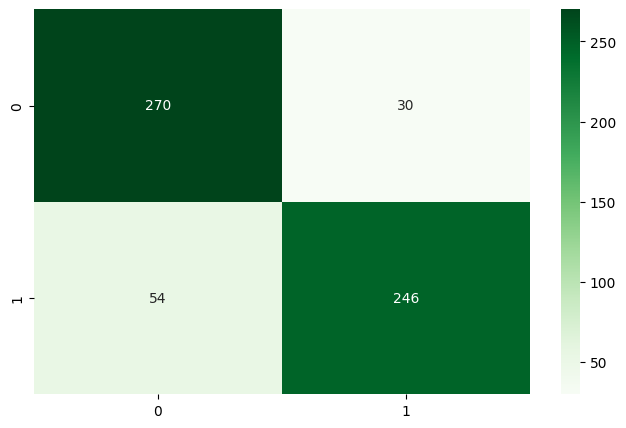

In [39]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

**Saving the model**

In [41]:
#Saving 85% accuracy model
#model.save('/content/drive/MyDrive/140K_code/140K_Dataset_3000_images/model_86_accuracy.h5')
model.save('/content/drive/MyDrive/140K_code/140K_Dataset_3000_images/model_86_accuracy.keras')
#model.save('/content/drive/model_86_accuracy.keras')